# 第7部　時系列予測の実践的技術

## 第2章　時系列分析の実践におけるTips

### 分析の準備

In [1]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# sktime：グラフ描画
from sktime.utils.plotting import plot_series

# 再帰的に回帰分析を実行するための関数の読み込み
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction

# sktime：予測の評価
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error, MeanAbsoluteError,
    mean_absolute_percentage_error, mean_absolute_error
)

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns
import matplotlib.dates as mdates
sns.set()

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### 時系列データの補間

#### ランダムウォーク系列の生成

In [3]:
# 乱数の種
np.random.seed(1)

# 正規分布に従う乱数の累積和を作成し、ランダムウォーク系列を作る
sim_size = 100
rw = pd.DataFrame(
    {'rw':np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))},
    index=pd.date_range(start='2000-01-01', periods=sim_size, freq='D')
)

In [4]:
# 欠測入りの系列
rw_missing = rw.copy()

# 1時点を欠測とする
rw_missing.loc['2000-01-03'] = None

# 結果の確認
print(rw_missing.head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03       NaN
2000-01-04 -0.588551
2000-01-05  0.276856


#### 1時点の補間

In [5]:
# 欠測値の補間
print(rw_missing.interpolate().head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03  0.212019
2000-01-04 -0.588551
2000-01-05  0.276856


In [6]:
# interpolateメソッドを使わない実装
(rw_missing.loc['2000-01-02'] + rw_missing.loc['2000-01-04']) / 2

rw    0.212019
dtype: float64

#### 長期間の補間

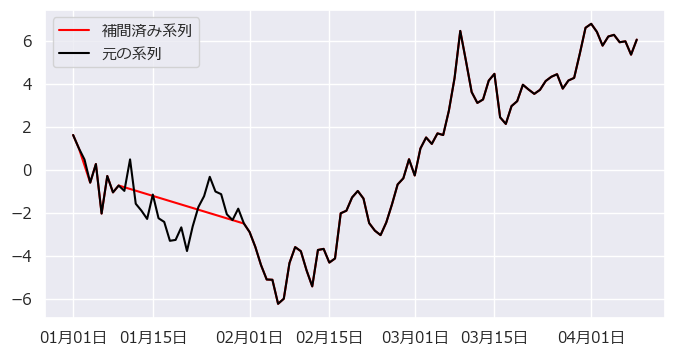

In [7]:
# 21時点連続で欠測
rw_missing.loc['2000-01-10':'2000-01-30'] = None

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
ax.plot(rw_missing.interpolate(), label='補間済み系列', color='red')
ax.plot(rw, label='元の系列', color='black')

# 凡例
ax.legend()

# 軸ラベルのフォーマット
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m月%d日'))

### 状態空間モデルによる補間

#### 飛行機乗客数データの読み込み

In [8]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset('AirPassengers').data

# 日付インデックスの作成(DatetimeIndex)
date_index = pd.date_range(
    start='1949-01', periods=len(air_passengers), freq='MS')
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [9]:
# データの2年間を欠測にする
air_passengers.loc['1955':'1956'] = None

#### 状態空間モデルの推定と補間

In [10]:
# ローカルレベルモデル
mod_ll = tsa.UnobservedComponents(
    air_passengers,         # 対象データ
    level='local level'     # ローカルレベル
).fit()

# 季節変動ありのローカル線形トレンドモデル
mod_bsts = tsa.UnobservedComponents(
    air_passengers,                 # 対象データ
    level='local linear trend',     # ローカル線形トレンド
    seasonal=12                     # 周期
).fit()

<Axes: >

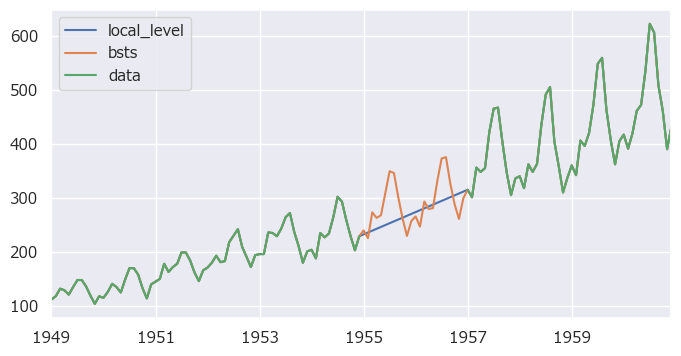

In [11]:
# DataFrameにまとめる
plot_df = pd.DataFrame({
    'local_level': mod_ll.level['smoothed'],
    'bsts': mod_bsts.level['smoothed'] + mod_bsts.seasonal['smoothed'],
    'data': air_passengers['value']
})

# 可視化
plot_df.plot()

### 日付の抜け漏れ

In [12]:
# 日付の欠測があるデータ
rw_lack = rw.copy()
rw_lack = rw_lack.drop(
    pd.date_range(start='2000-01-04', periods=20, freq='D'))

# 結果の確認
print(rw_lack.head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03  0.484417
2000-01-24 -1.219103
2000-01-25 -0.318247


In [13]:
# 日付の抜け漏れを欠測扱いにする
print(rw_lack.asfreq('D').head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03  0.484417
2000-01-04       NaN
2000-01-05       NaN


### データのリークに注意

#### 1次のARモデルによる誤った長期予測

In [14]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset('AirPassengers').data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(
    start='1949-01', periods=len(air_passengers), freq='M')
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# 訓練データとテストデータに分割する
train_air, test_air = temporal_train_test_split(air_passengers, test_size=36)

# 予測期間
fh_air = np.arange(1, len(test_air) + 1)

In [15]:
# 予測器(線形回帰モデル)
regressor_ar = LinearRegression()

# 再帰的に回帰分析を実行
forecaster_ar = make_reduction(regressor_ar, window_length=1, strategy="recursive")
forecaster_ar.fit(train_air)

# 推定されたパラメータ
params = forecaster_ar.get_fitted_params()

intercept = params['estimator__intercept']
coef = params['estimator__coef'][0]

# 結果の確認
print('intercept:', intercept)
print('coef:     ', coef)

intercept: 13.118081409372223
coef:      0.952049318694247


In [16]:
 # 2時点目以降の予測
ar_pred = intercept + coef * air_passengers.shift(1).loc[test_air.index]

# 予測結果
print(ar_pred.head(3))

              value
1958-01  333.006652
1958-02  336.814850
1958-03  315.869765


In [17]:
# 予測精度
mae = mean_absolute_error(test_air, ar_pred)
mase = mean_absolute_scaled_error(
    test_air, ar_pred, y_train=train_air)

print('MAE :', mae)
print('MASE:', mase)

MAE : 42.54651676508815
MASE: 2.094055792945921


#### 正しい長期予測

In [18]:
# 正しい長期予測の作り方
# 予測値を格納する入れ物
ar_pred_2 = pd.DataFrame({'value': np.zeros(len(test_air))},
                        index=test_air.index)

# 1時点目の予測は、訓練データの最後の時点の実測値を使う
ar_pred_2.loc['1958-01'] = intercept + coef * train_air.loc['1957-12'].iloc[0]

# 2時点目以降の予測は、1時点前の予測値を使う
for i in range(1, len(ar_pred_2)):
    ar_pred_2.iloc[i] = intercept + coef * ar_pred_2.iloc[i - 1]

# 予測結果
print(ar_pred_2.head(3))

              value
1958-01  333.006652
1958-02  330.156838
1958-03  327.443674


In [19]:
# sktimeによる予測結果と一致する
all(forecaster_ar.predict(fh=fh_air) == ar_pred_2)

True

In [20]:
# 予測精度
mae = mean_absolute_error(test_air, ar_pred_2)
mase = mean_absolute_scaled_error(
    test_air, ar_pred_2, y_train=train_air)

print('MAE :', mae)
print('MASE:', mase)

MAE : 127.04227618648179
MASE: 6.252770723069711


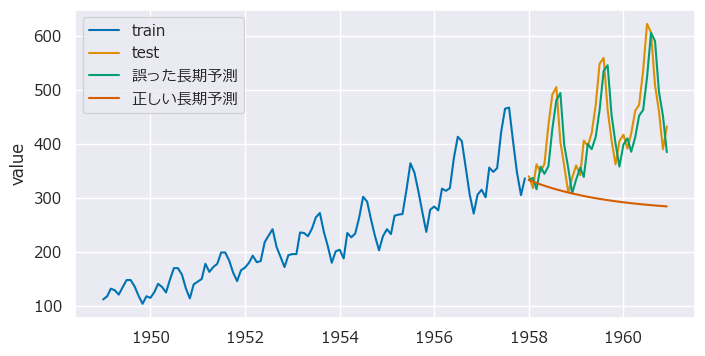

In [21]:
# 予測結果の可視化
fig, ax = plot_series(train_air, test_air, 
                      ar_pred, ar_pred_2,
                      labels=['train', 'test', '誤った長期予測', 
                              '正しい長期予測'], 
                      markers=np.tile('', 4))
fig.set_size_inches(8, 4)